<a href="https://colab.research.google.com/github/VitalyGladyshev/gb_dl_cv/blob/main/vs_hw_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 7
Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH


## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3MB 12.8MB/s 


## Загрузка и распаковка датасета KTH

In [ ]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [ ]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [ ]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 180


## Визуализация кадра из видео

videodata shape: (477, 120, 160, 3)


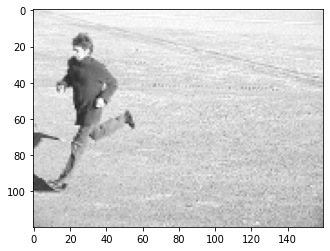

In [ ]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (476, 120, 160, 1)


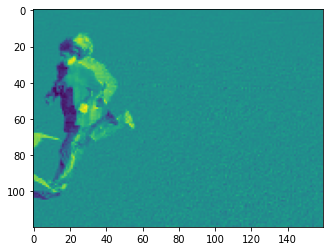

In [ ]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

## Создание модели CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [ ]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 476, 120, 160, 1)
Output shape: (1, 6)


## Подготовка к обучению

In [ ]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

## Цикл обучения модели

In [ ]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/180] Loss = 1.822139024734497
[0/10][10/180] Loss = 5.127295970916748
[0/10][20/180] Loss = 1.6826215982437134
[0/10][30/180] Loss = 1.7788540124893188
[0/10][40/180] Loss = 1.8357869386672974
[0/10][50/180] Loss = 1.8180845975875854
[0/10][60/180] Loss = 1.791070818901062
[0/10][70/180] Loss = 1.8014373779296875
[0/10][80/180] Loss = 1.7790217399597168
[0/10][90/180] Loss = 1.7809165716171265
[0/10][100/180] Loss = 2.022275447845459
[0/10][110/180] Loss = 1.7145099639892578
[0/10][120/180] Loss = 1.5256881713867188
[0/10][130/180] Loss = 1.2169641256332397
[0/10][140/180] Loss = 1.715362310409546
[0/10][150/180] Loss = 1.8940485715866089
[0/10][160/180] Loss = 3.7484946250915527
[0/10][170/180] Loss = 1.689458966255188
[1/10][0/180] Loss = 2.35074520111084
[1/10][10/180] Loss = 2.019556760787964
[1/10][20/180] Loss = 1.2978458404541016
[1/10][30/180] Loss = 2.1155824661254883
[1/10][40/180] Loss = 1.4990105628967285
[1/10][50/180] Loss = 1.1608736515045166
[1/10][60/180] Loss

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Тестирование обученной модели

True class: boxing
Predicted class: boxing


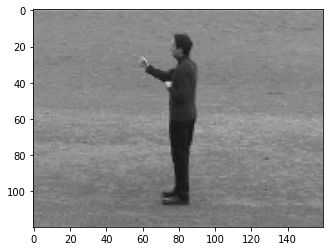

In [ ]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])